# Image Processing SoSe 22 - Assignment - 03

### Deadline is 12.05.2022 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.

In [41]:
# display the plots inside the notebook
%matplotlib inline

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import math
import ssl
from urllib.request import urlopen
from skimage.data import astronaut, brick
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb

pylab.rcParams['figure.figsize'] = (15, 15)   # This makes the plot bigger

# Exercise 1 - Bicubic interpolation - 4 Points

Implement affine transformation with [bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation).
Implement the functions `affine_transformation` and `bicubic_interpolation`. Apply some affine transformation of your choice and smooth the output using your bicubic interpolation.

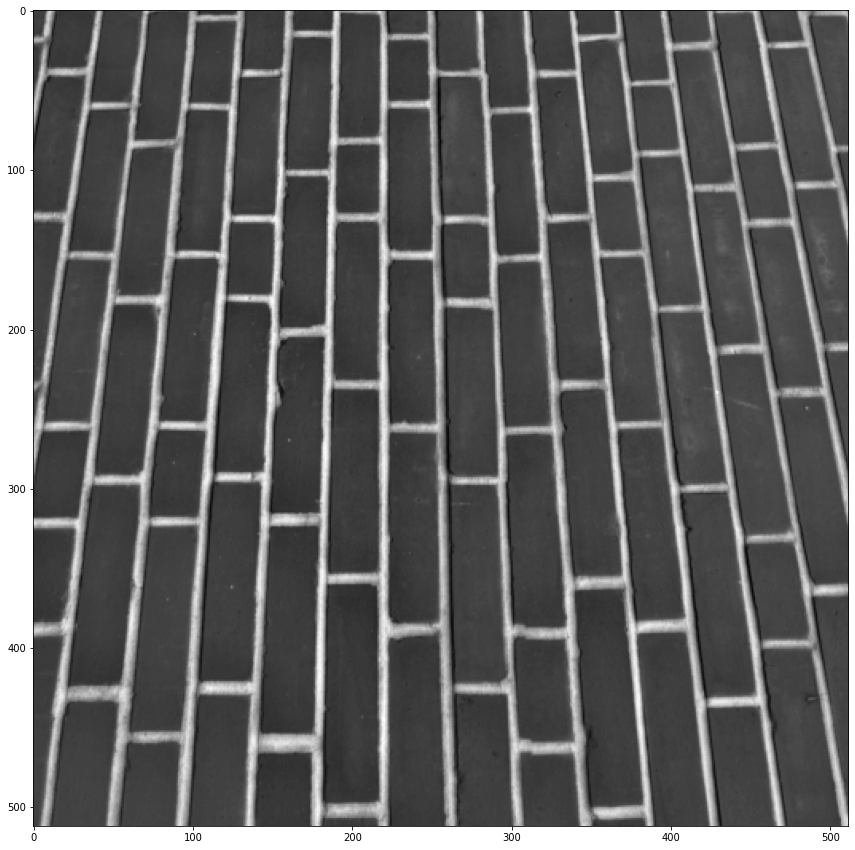

In [43]:
# We use a gray image. All the algorithms should work with color images too.
img = brick() / 255.
plt.imshow(img, cmap='gray')
plt.show()

In [44]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    return np.gradient(image, axis=1)


def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    return np.gradient(image, axis=0)

In [45]:
dx_img = derive_x(img)
dy_img = derive_y(img)

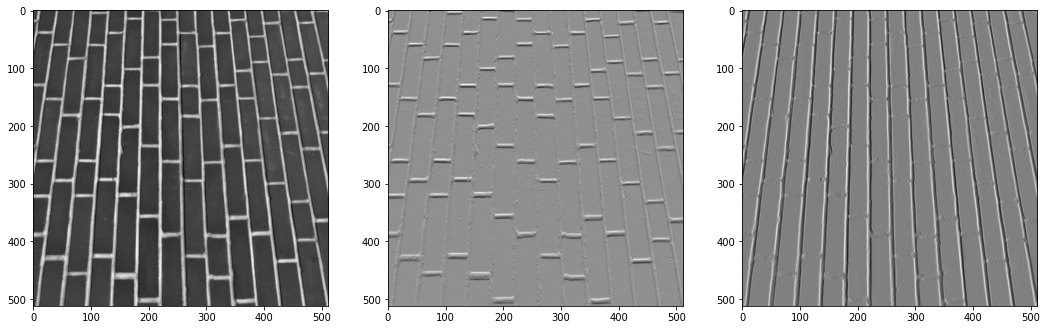

In [46]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

Here are some sample affine transformations to be used later on

In [47]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])
T_affine = np.array([
    [1, 0.3, 0],
    [0, 1, 0],
    [0, 0, 1],
])

# you can use this function to invert the matrices
np.linalg.inv(T_scale)

array([[1.33333333, 0.        , 0.        ],
       [0.        , 1.33333333, 0.        ],
       [0.        , 0.        , 1.        ]])

In [48]:
def affine_transformation(img, matrix):
    derived_image = np.zeros_like(img)
    dx_img = derive_x(img)
    dy_img = derive_y(img)
    dxy_img = derive_x(dy_img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            v = np.matmul(np.linalg.inv(matrix),np.array([x,y,1]))
            x_ori = v[0]
            y_ori = v[1]
            derived_image[x,y] = bicubic_interpolation(img,dx_img,dy_img,dxy_img,x_ori,y_ori)
    return derived_image


def bicubic_interpolation(img,dx_img,dy_img,dxy_img, x,y):
    f = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    A_inv = [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
             [-3,3,0,0,-2,-1,0,0,0,0,0,0,0,0,0,0],
             [2,-2,0,0,1,1,0,0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
             [0,0,0,0,0,0,0,0,-3,3,0,0,-2,-1,0,0],
             [0,0,0,0,0,0,0,0,2,-2,0,0,1,1,0,0],
             [-3,0,3,0,0,0,0,0,-2,0,-1,0,0,0,0,0],
             [0,0,0,0,-3,0,3,0,0,0,0,0,-2,0,-1,0],
             [9,-9,-9,9,6,3,-6,-3,6,-6,3,-3,4,2,2,1],
             [-6,6,6,-6,-3,-3,3,3,-4,4,-2,2,-2,-2,-1,-1],
             [2,0,-2,0,0,0,0,0,1,0,1,0,0,0,0,0],
             [0,0,0,0,2,0,-2,0,0,0,0,0,1,0,1,0],
             [-6,6,6,-6,-4,-2,4,2,-3,3,-3,3,-2,-1,-2,-1],
             [4,-4,-4,4,2,2,-2,-2,2,-2,2,-2,1,1,1,1]]
    if x > img.shape[0]-1 or x <0 or y > img.shape[1]-1 or y < 0:
        return 0
    else:
        x0 = math.floor(x)
        x1 = math.ceil(x)
        y0 = math.floor(y)
        y1 = math.ceil(y)
        f[0] = img[x0,y0]
        f[1] = img[x1,y0]
        f[2] = img[x0,y1]
        f[3] = img[x1,y1]
        f[4] = dx_img[x0,y0]
        f[5] = dx_img[x1,y0]
        f[6] = dx_img[x0,y1]
        f[7] = dx_img[x1,y1]
        f[8] = dy_img[x0,y0]
        f[9] = dy_img[x1,y0]
        f[10] = dy_img[x0,y1]
        f[11] = dy_img[x1,y1]
        f[12] = dxy_img[x0,y0]
        f[13] = dxy_img[x1,y0]
        f[14] = dxy_img[x0,y1]
        f[15] = dxy_img[x1,y1]
        a = np.matmul(A_inv, f)
        x = x-x0
        y = y-y0
        p = a[0] + a[1]*x + a[2]*(x**2) + a[3]*(x**3) + a[4]*y +a[5]*x*y + a[6]*(x**2)*y + a[7]*(x**3)*y + a[8]*(y**2) +a[9]*x*(y**2) + a[10]*(x**2)*(y**2) + a[11]*(x**3)*(y**2) + a[12]*(y**3) +a[13]*x*(y**3) + a[14]*(x**2)*(y**3) + a[15]*(x**3)*(y**3)
        return p

In [49]:
img_scale = affine_transformation(img, T_scale)
img_affine = affine_transformation(img, T_affine)

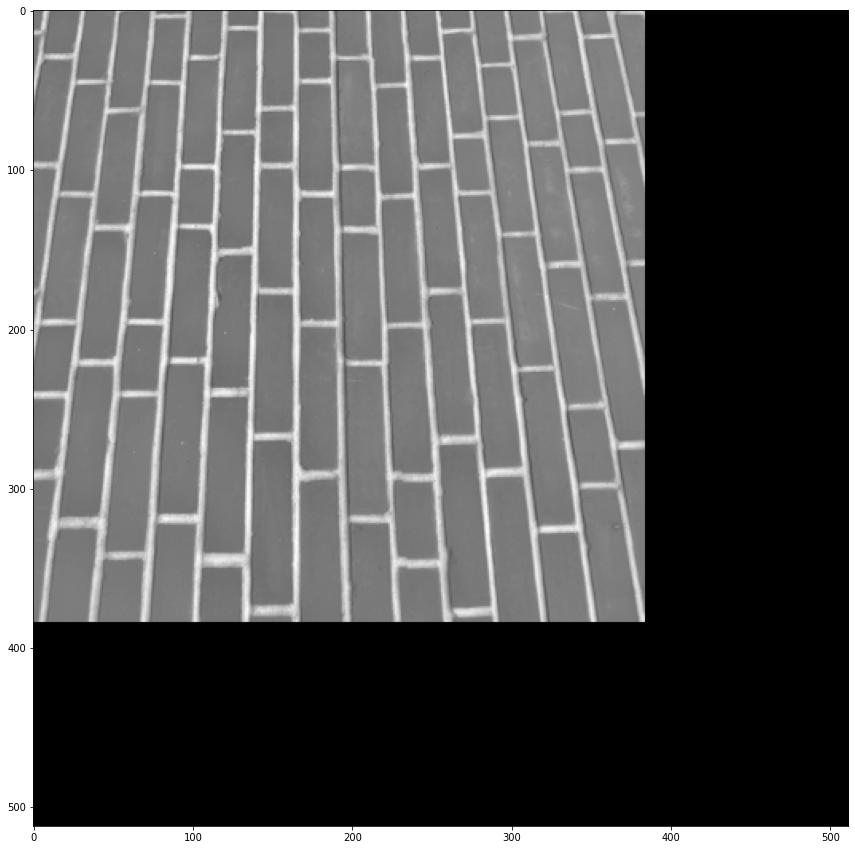

In [50]:
plt.imshow(img_scale, cmap='gray')
plt.show()

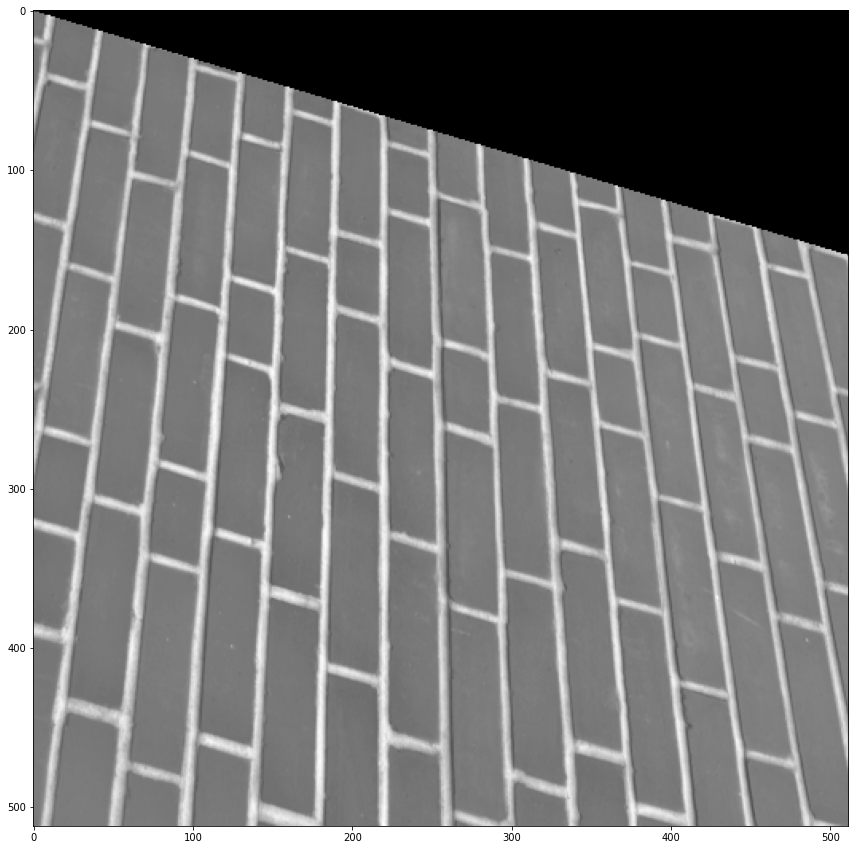

In [51]:
plt.imshow(img_affine, cmap='gray')
plt.show()

# Exercise 2 - Implement a Histogram Mapping - 2 Points

In [52]:
def norm_cdf(arr):
    return arr / arr[-1]

In [53]:
def gamma_mapping(gamma):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is `(n/len(array))**gamma`.
    """
    return norm_cdf(np.linspace(0, 1, 256)**gamma)


def sigmoid_mapping(gain = 10, cutoff = 0.5):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is  `1/(1 + exp*(gain*(cutoff - (n/len(array)))))`.
    """
    sig = np.zeros(256)
    for n in range (256):
        sig[n] = 1/(1+math.exp((gain*(cutoff-(n/256)))))
    return sig

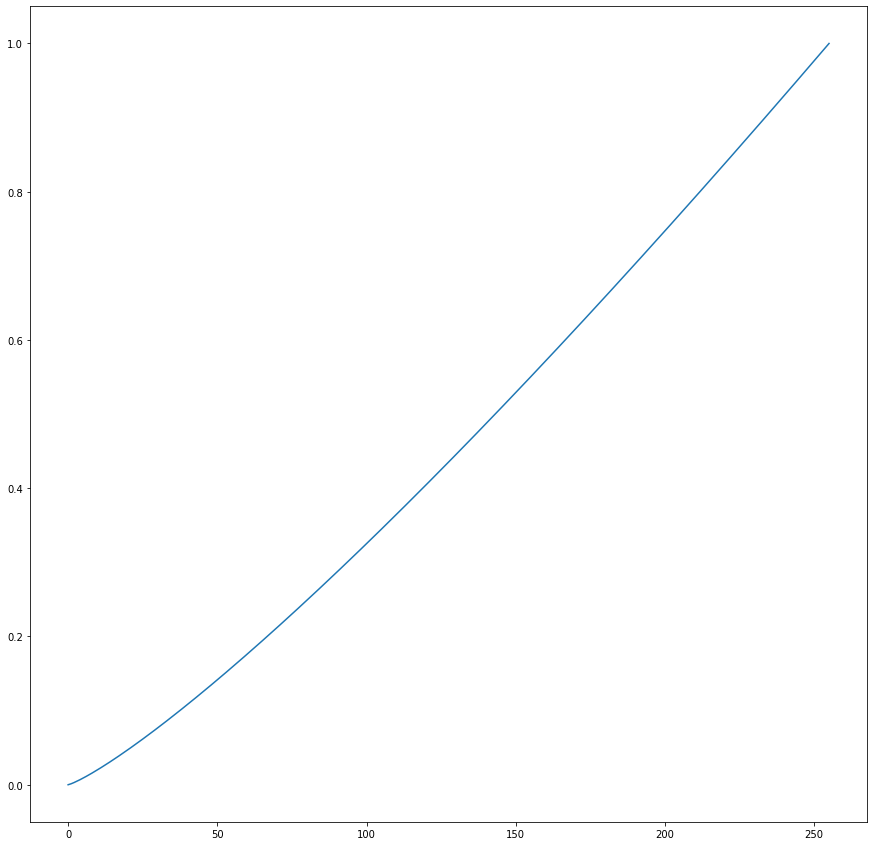

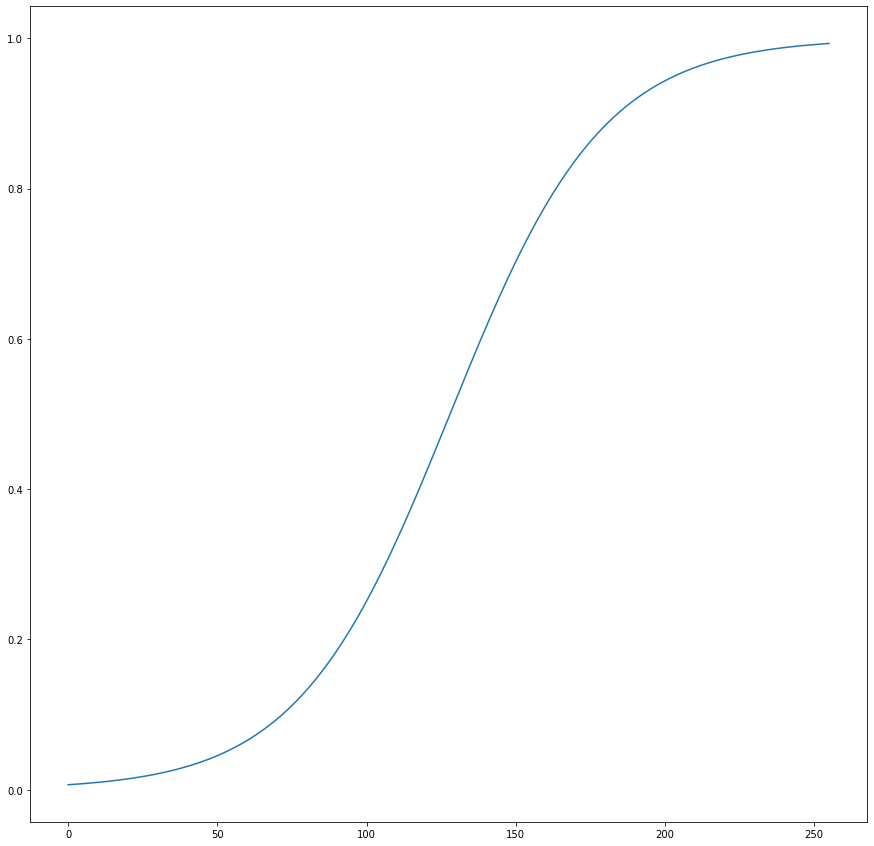

In [54]:
plt.plot(gamma_mapping(1.2))
plt.show()

plt.plot(sigmoid_mapping())
plt.show()

# Exercise 3 - Histogram Transformation - 2 Points

In [55]:
img = astronaut() / 255.
img_hsv = rgb2hsv(img)
img_gray = rgb2gray(img)

In [56]:
def apply_pixel_mapping(image, mapping):
    """Returns the image transformed according to the mapping array. 
       `mapping` is a one dimensional numpy array. `image` can be 2 or 3-dimensional.
       The values of the image are in range 0 to 1. 
       If the mapping has for example 255 items, then all pixel with a value from 0 to 1/255 are assigned to 
       the value mapping[0]. If the pixel is between n / 255 and (n+1) / 255 then the value in the output image should 
       be mapping[n]
    """
    image = image*255
    derived_image = np.zeros_like(image)
    for x in range (image.shape[0]):
        for y in range(image.shape[1]):
            if len(image.shape) == 3:
                for i in range (image.shape[2]):
                    derived_image[x][y][i] = mapping[int(image[x][y][i])]
            else:
                derived_image[x][y] = mapping[int(image[x][y])]
    return derived_image

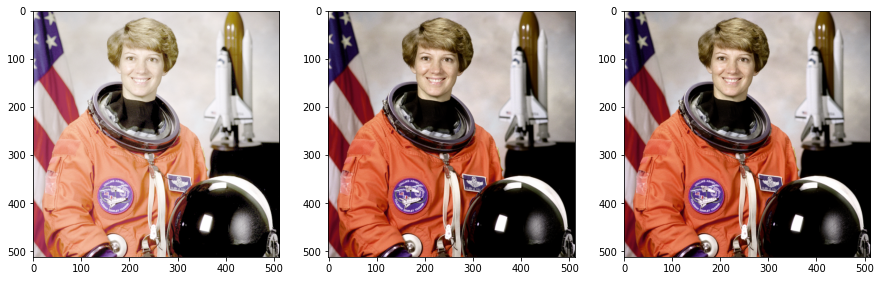

In [57]:
# you can test your `apply_pixel_mapping` function
# The first image should look lighter. The second and third should be the same image.
img_gamma05 = apply_pixel_mapping(img, gamma_mapping(0.5))
plt.subplot(131)
plt.imshow(img_gamma05, cmap='gray')
plt.subplot(132)
plt.imshow(apply_pixel_mapping(img_gamma05, gamma_mapping(2)), cmap='gray')
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.show()

# Exercise 4 - Implement Histogram Equalisation - 2 Points

Equalize the image given image so that the histogram is mostly uniform distributed.
You can use `np.histogram` and `np.cumsum`. Checkout the documentation of `np.histogram`, it might have useful optional arguments.

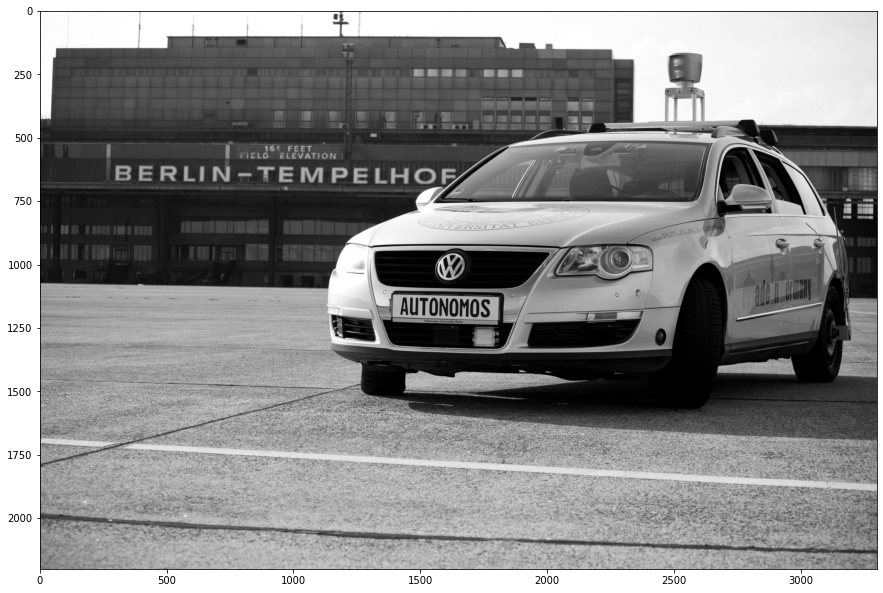

In [58]:
# bypass certficate check here since there are sometimes problems with urllib
ssl._create_default_https_context = ssl._create_unverified_context
f = urlopen("https://autonomos.inf.fu-berlin.de/wp-content/gallery/press-conference-2011/IMG_0471.jpg")
car = rgb2gray(plt.imread(f, format='jpeg'))
plt.imshow(car, cmap='gray')
plt.show()

In [59]:
hist = np.histogram(car,bins=256)[0] # get the histogram of the image
cumsum=np.cumsum(hist)
equalisation_mapping = cumsum/max(cumsum) # calculate the right mapping

In [60]:
img_equalised = apply_pixel_mapping(car, equalisation_mapping)

In [61]:
hist_of_equalised = np.histogram(img_equalised,bins=256)[0] # get the histogram of the equalised image

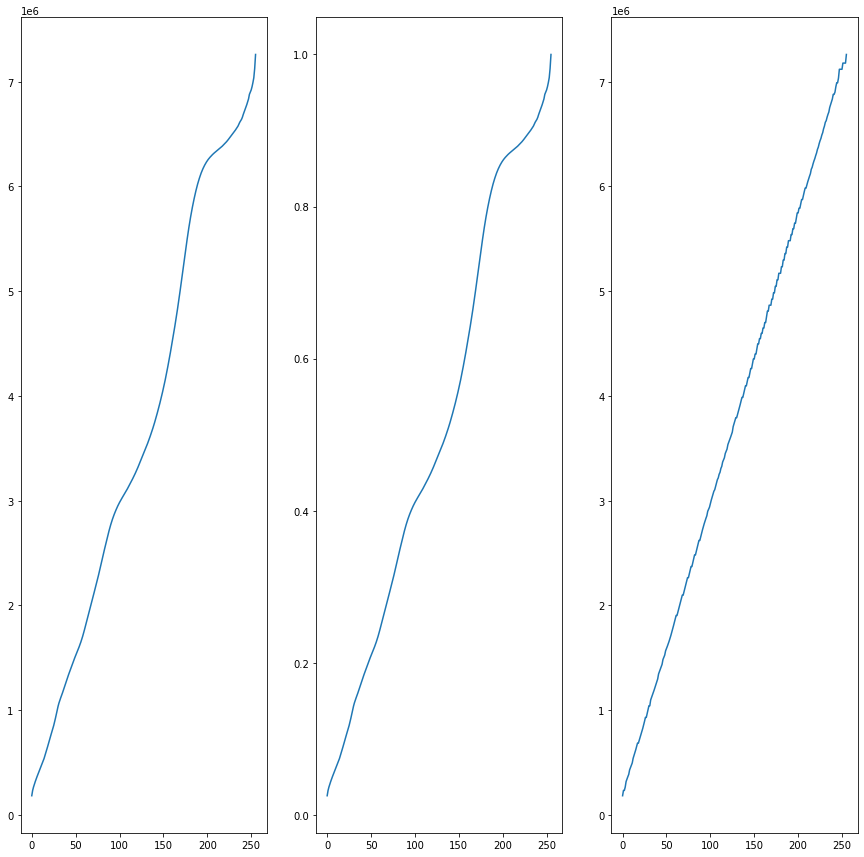

In [62]:
plt.subplot(131)
plt.plot(hist.cumsum())
plt.subplot(132)
plt.plot(equalisation_mapping)
plt.subplot(133)
plt.plot(hist_of_equalised.cumsum())
plt.show()

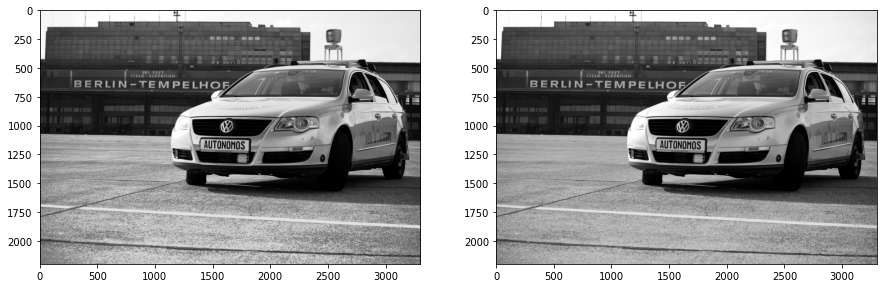

In [63]:
plt.subplot(121)
plt.imshow(img_equalised, cmap='gray')
plt.subplot(122)
plt.imshow(car, cmap='gray')
plt.show()